# The final model
 

## Model v2.1

In [1]:
model_name = f'3.33-v2.1'

In [2]:
import warnings

from sklearn.metrics import root_mean_squared_error

warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
from data import load_data

_, augmented_data, test_data = load_data()

In [4]:
augmented_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168588 entries, p01_test_12 to p24_test_94938
Columns: 507 entries, p_num to bg+1:00
dtypes: float64(433), object(74)
memory usage: 657.4+ MB


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3644 entries, p01_8459 to p24_260
Columns: 506 entries, p_num to activity-0:00
dtypes: float64(432), object(74)
memory usage: 14.2+ MB


# Prepare the data

In [6]:
from pipelines import pipeline

train_data_transformed = pipeline.fit_transform(augmented_data)

X_train = train_data_transformed.drop(columns=['bg+1:00'])
y_train = train_data_transformed['bg+1:00']

## Predict for validation data and check results

In [7]:
import dnns
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor

create_dnn_model = dnns.create_model_MA01I


def model_with_pretrained_weights():
    dnn = create_dnn_model(X_train.shape[1])
    dnn.load_weights(f'{model_name}.weights.h5')  # Load the pre-trained weights

    # Freeze all layers except the last one (optional)
    for layer in dnn.layers:
        layer.trainable = False
    # Unfreeze the output layer if you want to fine-tune it
    # dnn.layers[-1].trainable = True

    dnn.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=[dnns.rmse]
    )
    return dnn


Epoch 1/100
4215/4215 - 6s - 1ms/step - loss: 9.4920 - rmse: 2.8972 - val_loss: 5.4727 - val_rmse: 2.0552
Epoch 2/100
4215/4215 - 5s - 1ms/step - loss: 6.3661 - rmse: 2.4633 - val_loss: 5.5944 - val_rmse: 2.0829
Epoch 3/100
4215/4215 - 5s - 1ms/step - loss: 5.4455 - rmse: 2.2939 - val_loss: 5.2942 - val_rmse: 2.0235
Epoch 4/100
4215/4215 - 5s - 1ms/step - loss: 5.0021 - rmse: 2.1964 - val_loss: 5.1213 - val_rmse: 2.0002
Epoch 5/100
4215/4215 - 5s - 1ms/step - loss: 4.7580 - rmse: 2.1439 - val_loss: 5.0290 - val_rmse: 1.9957
Epoch 6/100
4215/4215 - 7s - 2ms/step - loss: 4.6009 - rmse: 2.1068 - val_loss: 5.0364 - val_rmse: 2.0017
Epoch 7/100
4215/4215 - 5s - 1ms/step - loss: 4.5425 - rmse: 2.0920 - val_loss: 5.1032 - val_rmse: 2.0073
Epoch 8/100
4215/4215 - 5s - 1ms/step - loss: 4.4943 - rmse: 2.0806 - val_loss: 5.0438 - val_rmse: 2.0028
Epoch 9/100
4215/4215 - 10s - 2ms/step - loss: 4.4783 - rmse: 2.0748 - val_loss: 5.2698 - val_rmse: 2.0348
Epoch 10/100
4215/4215 - 5s - 1ms/step - loss

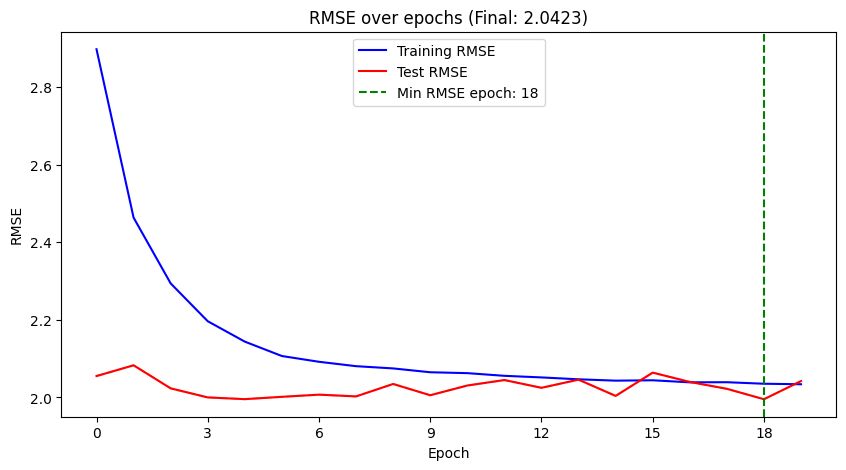

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LassoLarsIC, Ridge
from tensorflow.keras.callbacks import EarlyStopping
from model_performance_calculations import get_history_line_chart

hgb_estimator = HistGradientBoostingRegressor(
    max_depth=4,
    learning_rate=0.05,
    max_iter=500,
    min_samples_leaf=20,
    early_stopping='auto',
    validation_fraction=0.1,
    n_iter_no_change=10,
    verbose=0
)

lasso_lars_ic_base_model = LassoLarsIC(
    criterion='aic',
    eps=0.03922948513965659,
    max_iter=1944,
    noise_variance=5.4116687755186035e-05,
    positive=False,
)

knn_base_estimator = KNeighborsRegressor(
    leaf_size=30,
    metric='minkowski',
    n_neighbors=7,
    p=2,
    weights='distance'
)

xgb_base_estimator = XGBRegressor(
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.01,
    colsample_bytree=0.8,
    subsample=0.8,
    objective='reg:squarederror',
    random_state=42,
)

# pretrain the DNN and use the weights in the stacking model
pretrained_dnn = create_dnn_model(X_train.shape[1])
pretrained_dnn.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=2,
    validation_split=0.2,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

history = pretrained_dnn.history.history
pretrained_dnn.save_weights(f'{model_name}.weights.h5')

keras_regressor = KerasRegressor(
    model=model_with_pretrained_weights,
    epochs=1,
    verbose=2
)

estimators = [
    ('hgb', hgb_estimator),
    ('lasso_lars_ic', lasso_lars_ic_base_model),
    ('knn', knn_base_estimator),
    ('xgb', xgb_base_estimator),
    ('dnn', keras_regressor)
]

model = StackingRegressor(estimators=estimators, final_estimator=Ridge(alpha=0.1), n_jobs=1, verbose=2)

get_history_line_chart([history]).show()

12:34:23 - Start training
12:34:23 - Calculate performance for hgb
12:34:23 - Split 1 - Model: hgb
12:34:23 - Fitting the model
12:34:57 - Predicting
12:34:57 - Calculating scores
12:34:57 - R^2: 0.6166846208504034, RMSE: 2.0292512458233816, MAE: 1.5124518906918298, MSE: 4.1178606186757465
12:34:57 - Split 2 - Model: hgb
12:34:57 - Fitting the model
12:35:09 - Predicting
12:35:10 - Calculating scores
12:35:10 - R^2: 0.6116350769806574, RMSE: 2.0239788274699984, MAE: 1.5228853023805928, MSE: 4.096490294046829
12:35:10 - Split 3 - Model: hgb
12:35:10 - Fitting the model
12:35:24 - Predicting
12:35:24 - Calculating scores
12:35:24 - R^2: 0.6164953490177442, RMSE: 2.0296835681999723, MAE: 1.5153058757730342, MSE: 4.119615387020972
12:35:24 - Split 4 - Model: hgb
12:35:24 - Fitting the model
12:35:37 - Predicting
12:35:38 - Calculating scores
12:35:38 - R^2: 0.6156181673855308, RMSE: 2.0373530495968235, MAE: 1.5203375753356725, MSE: 4.150807448701477
12:35:38 - Split 5 - Model: hgb
12:35:38

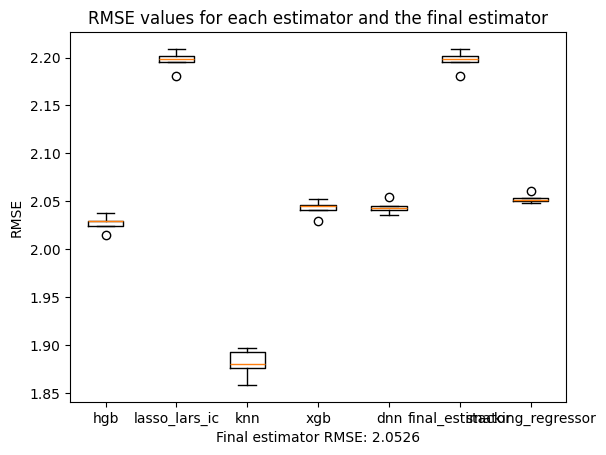

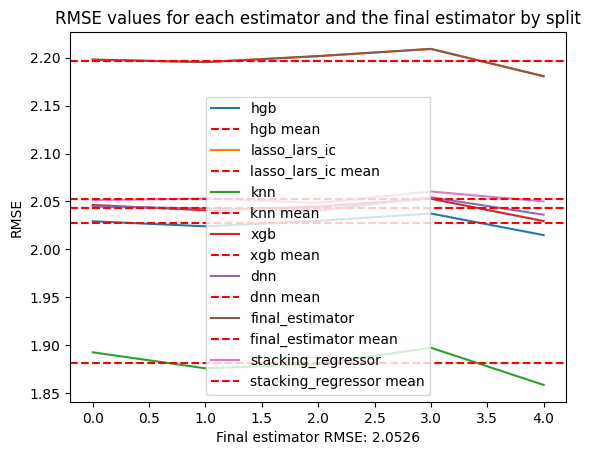

In [9]:
from datetime import datetime
import os
from model_performance_calculations import calculate_stacking_regressor_performance, get_rmse_boxplot_chart, get_rmse_line_chart, save_performances, save_model

date_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

save_model(model, os.path.join('models', f'{model_name}.pkl'))

performances = calculate_stacking_regressor_performance(model, X_train, y_train, n_splits=5)
save_performances(performances, os.path.join('models', f'{model_name}-performances.json'))

get_rmse_boxplot_chart(performances).show()
get_rmse_line_chart(performances).show()

In [10]:
import numpy as np
from pipelines import pipeline

train_data_transformed = pipeline.fit_transform(augmented_data)

X_train = train_data_transformed.drop(columns=['bg+1:00'])
y_train = train_data_transformed['bg+1:00']

model.fit(X_train, y_train)

X_test = pipeline.transform(test_data)
y_pred = model.predict(X_test)

if np.sum(y_pred < 0) > 0:
    print(f'Number of negative values: {np.sum(y_pred < 0)}')
    bg_min_train = np.min(y_train)
    print(f'Min value: {np.min(y_pred)}')
    print(f'Filling negative values with {bg_min_train}')
    y_pred = np.where(y_pred < 0, bg_min_train, y_pred)

test_data['bg+1:00'] = y_pred
test_data.head()

5269/5269 - 2s - 375us/step - loss: 4.5361 - rmse: 4.0586
4215/4215 - 3s - 674us/step - loss: 4.3188 - rmse: 4.0406
1054/1054 - 1s - 1ms/step
4215/4215 - 3s - 654us/step - loss: 4.6657 - rmse: 3.9852
1054/1054 - 1s - 637us/step
4215/4215 - 3s - 687us/step - loss: 4.7464 - rmse: 4.1416
1054/1054 - 1s - 614us/step
4215/4215 - 3s - 710us/step - loss: 4.6216 - rmse: 4.1287
1054/1054 - 1s - 661us/step
4215/4215 - 3s - 656us/step - loss: 4.3144 - rmse: 3.9787
1054/1054 - 1s - 612us/step
114/114 - 0s - 1ms/step


,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
id,,,,,,,,,,,,,,,,,,,,,
p01_8459,p01,06:45:00,NaN,9.2,NaN,NaN,10.2,NaN,NaN,10.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.705307
p01_8460,p01,11:25:00,NaN,NaN,9.9,NaN,NaN,9.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Walk,Walk,Walk,6.623675
p01_8461,p01,14:45:00,NaN,5.5,NaN,NaN,5.5,NaN,NaN,5.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.398540
p01_8462,p01,04:30:00,NaN,3.4,NaN,NaN,3.9,NaN,NaN,4.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.053415
p01_8463,p01,04:20:00,NaN,NaN,8.3,NaN,NaN,10.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.722765


In [11]:
submission = pd.DataFrame(test_data['bg+1:00'])
submission

,bg+1:00
id,
p01_8459,8.705307
p01_8460,6.623675
p01_8461,7.398540
p01_8462,12.053415
p01_8463,7.722765
...,...
p24_256,6.565970
p24_257,12.430555
p24_258,6.615336


In [12]:
submission.to_csv(f'submission-model-{model_name}.csv')

In [13]:
y_pred = model.predict(X_train)

root_mean_squared_error(y_train, y_pred)


5269/5269 - 3s - 663us/step


np.float64(2.088031430287873)

In [14]:
from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(y_train, y_pred)

np.float64(2.088031430287873)